In [0]:
%matplotlib inline
import torch
from torchvision import transforms, models
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [0]:
vgg = models.vgg19(pretrained = True).features

for params in vgg.parameters():
  params.requires_grad = False

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
def load_image(img_path, max_size=400, shape=None):
  image = Image.open(img_path).convert('RGB')
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)
  
  if shape is not None:
    size = shape
  
  in_transform = transforms.Compose([
      transforms.Resize(size),
      transforms.ToTensor(),
      transforms.Normalize((0.5,0.5,0.5),
                          (0.5,0.5,0.5))
  ])
  
  image = in_transform(image).unsqueeze(0)
  
  return image

In [0]:
content = load_image('Sarmad.jpg').to(device)
print(content.shape)
style = load_image('Colours.jpg', shape=content.shape[-2:]).to(device)
print(style.shape)

torch.Size([1, 3, 400, 600])
torch.Size([1, 3, 400, 600])


In [ ]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.squeeze()
  image = image.transpose(1,2,0)
  image = image*(0.5,0.5,0.5)+(0.5,0.5,0.5)
  return image

In [ ]:
plt.imshow(im_convert(content))

In [0]:
def get_features(image, model):
  
  layers = {
      '0':'conv1-1',
      '5':'conv2-1',
      '10':'conv3-1',
      '19':'conv4-1',
      '21':'conv4-2',
      '28':'conv5-1'
  }
  
  features={}
  
  for name,layer in model._modules.items():
    image = layer(image)
    if name in layers:
      features[layers[name]] = image
      
  
  return features

In [0]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [0]:
def gram_matrix(tensor):
  _, d, h, w = tensor.size()
  tensor = tensor.view(d, h*w)
  gram = torch.mm(tensor, tensor.t())
  return gram

In [0]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

style_weights = {
    'conv1-1':1.0,
    'conv2-1':.75,
    'conv3-1':0.2,
    'conv4-1':0.2,
    'conv5-1':0.2
}

content_weight = 1
style_weight = 1e6

In [0]:
target = content.clone().requires_grad_(True).to(device)

In [0]:
show_every = 300
optimizer = torch.optim.Adam([target], lr=0.003)
steps = 2100

height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps/300
counter = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration: 300, total loss 38634692.0


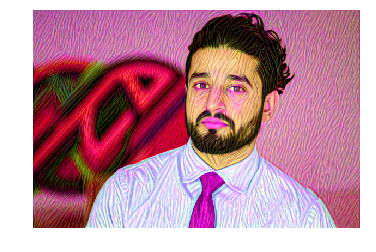

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration: 600, total loss 13756361.0


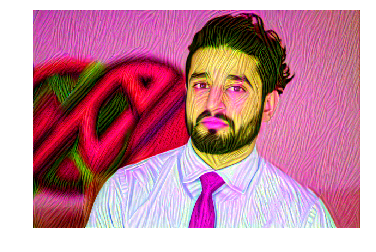

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration: 900, total loss 6912653.0


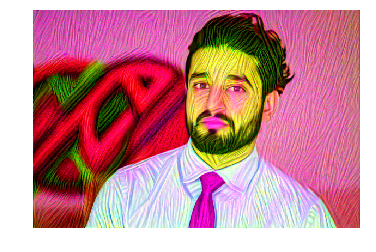

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration: 1200, total loss 4088126.5


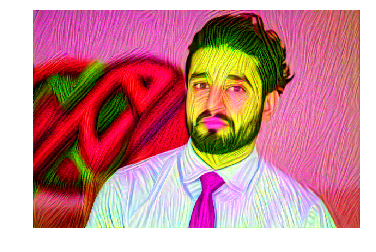

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration: 1500, total loss 2922331.5


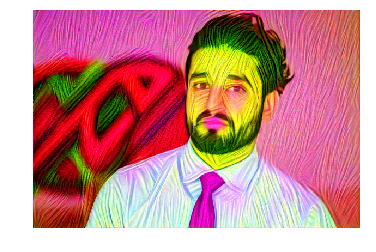

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration: 1800, total loss 2272361.0


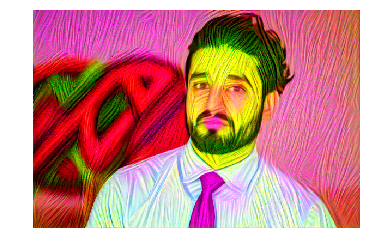

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration: 2100, total loss 1829098.25


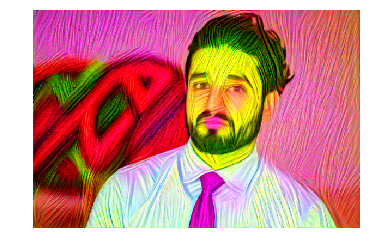

In [0]:
from google.colab import files

for ii in range(1, steps+1):
  target_features = get_features(target, vgg)
  content_loss = torch.mean((target_features['conv4-2']-content_features['conv4-2'])**2)
  style_loss = 0
  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer]*torch.mean((target_gram - style_gram)**2)
    _, d, h, w = target_feature.shape
    style_loss += layer_style_loss/(d*w*h)
    
  total_loss = content_loss * content_weight + style_loss * style_weight
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  if ii%show_every ==0:
    print('iteration: {}, total loss {}'.format(ii,total_loss.item()))
    plt.imshow(im_convert(target))
    plt.axis('off')
    plt.show()
    
  if ii%capture_frame ==0:
    image_array[counter] = im_convert(target)
    counter +=1

In [0]:
result = im_convert(target)
result = result.clip(0,1)
result = Image.fromarray((result * 255).astype(np.uint8))
result.save('result.jpg')
result

files.download('result.jpg')